In [11]:
!rm -rf /kaggle/working/*

In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar-10/trainLabels.csv
/kaggle/input/cifar-10/sampleSubmission.csv
/kaggle/input/cifar-10/test.7z
/kaggle/input/cifar-10/train.7z


In [13]:
!pip install py7zr

# Setup and Data Loading

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from PIL import Image
import os
import py7zr
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [15]:
# First, let's check what's actually in the input directory
print("Contents of input directory:")
for item in os.listdir('/kaggle/input/cifar-10'):
    print(f"  {item}")

# Extract files properly
def extract_7z_files():
    train_7z_path = '/kaggle/input/cifar-10/train.7z'
    test_7z_path = '/kaggle/input/cifar-10/test.7z'
    
    train_extract_path = '/kaggle/working/train'
    test_extract_path = '/kaggle/working/test'
    
    # Extract train data
    if not os.path.exists(train_extract_path):
        print("Extracting train.7z...")
        with py7zr.SevenZipFile(train_7z_path, mode='r') as z:
            z.extractall('./')
    
    # Extract test data  
    if not os.path.exists(test_extract_path):
        print("Extracting test.7z...")
        with py7zr.SevenZipFile(test_7z_path, mode='r') as z:
            z.extractall('./')
    
    # Check what was extracted
    print(f"Train files: {len(os.listdir(train_extract_path))}")
    print(f"Test files: {len(os.listdir(test_extract_path))}")
    
    # Show first few files
    print("First 5 train files:", sorted(os.listdir(train_extract_path))[:5])
    print("First 5 test files:", sorted(os.listdir(test_extract_path))[:5])

extract_7z_files()

Contents of input directory:
  trainLabels.csv
  sampleSubmission.csv
  test.7z
  train.7z
Extracting train.7z...
Extracting test.7z...
Train files: 50000
Test files: 300000
First 5 train files: ['1.png', '10.png', '100.png', '1000.png', '10000.png']
First 5 test files: ['1.png', '10.png', '100.png', '1000.png', '10000.png']


# Create Custom Dataset Class

In [16]:
class CIFAR10TrainDataset(Dataset):
    def __init__(self, labels_df, img_dir, transform=None):
        self.labels_df = labels_df
        self.img_dir = img_dir
        self.transform = transform
        
        # Map class names to integers
        self.classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                       'dog', 'frog', 'horse', 'ship', 'truck']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # Verify files exist
        self.valid_indices = []
        for idx in range(len(self.labels_df)):
            img_name = f"{self.labels_df.iloc[idx]['id']}.png"
            img_path = os.path.join(self.img_dir, img_name)
            if os.path.exists(img_path):
                self.valid_indices.append(idx)
            else:
                print(f"Warning: {img_path} not found")
        
        print(f"Found {len(self.valid_indices)} valid images out of {len(labels_df)}")
        
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        img_name = f"{self.labels_df.iloc[actual_idx]['id']}.png"
        img_path = os.path.join(self.img_dir, img_name)
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Get label
        label_name = self.labels_df.iloc[actual_idx]['label']
        label = self.class_to_idx[label_name]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

class CIFAR10TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        
        # Get all PNG files and sort them numerically
        self.image_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]
        self.image_files.sort(key=lambda x: int(x.split('.')[0]))
        
        print(f"Found {len(self.image_files)} test images")
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # Get image ID for submission (remove .png extension)
        img_id = int(img_name.split('.')[0])
        
        if self.transform:
            image = self.transform(image)
            
        return image, img_id

# Data Loading and Preprocessing

In [17]:
# Load and verify labels
labels_df = pd.read_csv("/kaggle/input/cifar-10/trainLabels.csv")
print(f"Training labels: {len(labels_df)}")
print(labels_df.head())
print(f"Unique labels: {labels_df['label'].unique()}")

# Check the actual extracted directories
train_img_dir = './train'
test_img_dir = './test'

print(f"Train directory exists: {os.path.exists(train_img_dir)}")
print(f"Test directory exists: {os.path.exists(test_img_dir)}")

if os.path.exists(train_img_dir):
    train_files = os.listdir(train_img_dir)
    print(f"Number of train images: {len(train_files)}")
    print(f"First 5 train files: {train_files[:5]}")
    
if os.path.exists(test_img_dir):
    test_files = os.listdir(test_img_dir) 
    print(f"Number of test images: {len(test_files)}")
    print(f"First 5 test files: {test_files[:5]}")

# Data transformations
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Create datasets
try:
    train_dataset = CIFAR10TrainDataset(labels_df, train_img_dir, transform=train_transform)
    
    # Split into train and validation
    train_indices, val_indices = train_test_split(
        range(len(train_dataset)), test_size=0.2, random_state=42, 
        stratify=labels_df.iloc[train_dataset.valid_indices]['label']
    )
    
    from torch.utils.data import Subset
    train_subset = Subset(train_dataset, train_indices)
    val_subset = Subset(train_dataset, val_indices)
    
    test_dataset = CIFAR10TestDataset(test_img_dir, transform=val_transform)
    
    # Create data loaders
    batch_size = 128
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    print(f"Train batches: {len(train_loader)}")
    print(f"Val batches: {len(val_loader)}") 
    print(f"Test batches: {len(test_loader)}")
    
except Exception as e:
    print(f"Error creating datasets: {e}")
    # Fallback: check what's actually in the directories
    if os.path.exists(train_img_dir):
        actual_files = set([f.split('.')[0] for f in os.listdir(train_img_dir) if f.endswith('.png')])
        expected_files = set([str(id) for id in labels_df['id'].values])
        missing = expected_files - actual_files
        print(f"Missing files: {len(missing)}")
        if missing:
            print(f"First 10 missing: {list(missing)[:10]}")

Training labels: 50000
   id       label
0   1        frog
1   2       truck
2   3       truck
3   4        deer
4   5  automobile
Unique labels: ['frog' 'truck' 'deer' 'automobile' 'bird' 'horse' 'ship' 'cat' 'dog'
 'airplane']
Train directory exists: True
Test directory exists: True
Number of train images: 50000
First 5 train files: ['10942.png', '14265.png', '31116.png', '25376.png', '11774.png']
Number of test images: 300000
First 5 test files: ['10942.png', '191325.png', '228935.png', '184194.png', '90560.png']
Found 50000 valid images out of 50000
Found 300000 test images
Train batches: 313
Val batches: 79
Test batches: 2344


# Model Architecture

In [18]:
class CIFAR10CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CIFAR10CNN, self).__init__()
        
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            
            # Block 2
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            
            # Block 3
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def create_model(num_classes=10):
    return CIFAR10CNN(num_classes).to(device)

# Training with Validation

In [21]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Training")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        pbar.set_postfix({
            'Loss': f"{running_loss/(batch_idx+1):.3f}",
            'Acc': f"{100.*correct/total:.2f}%"
        })
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validation")
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            pbar.set_postfix({
                'Loss': f"{running_loss/(batch_idx+1):.3f}",
                'Acc': f"{100.*correct/total:.2f}%"
            })
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


In [19]:
def train_model(model, train_loader, val_loader, epochs=100, patience=10):
    """
    Train CIFAR-10 model with early stopping.

    Args:
        model: PyTorch model
        train_loader: training DataLoader
        val_loader: validation DataLoader
        epochs: max number of epochs
        patience: how many epochs to wait for improvement before stopping
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    best_val_acc = 0.0
    best_epoch = 0
    patience_counter = 0

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 50)

        # Training
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)

        #  Validation
        val_loss, val_acc = validate_epoch(model, val_loader, criterion)

        # Update LR scheduler
        scheduler.step()

        # Record metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Early stopping 
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            patience_counter = 0  # reset counter
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, '/kaggle/working/best_model.pth')
            print(f" New best model saved with validation accuracy: {val_acc:.2f}%")
        else:
            patience_counter += 1
            print(f" No improvement for {patience_counter} epoch(s).")

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        #Check for early stopping
        if patience_counter >= patience:
            print(f"\n Early stopping triggered at epoch {epoch+1}. Best val acc: {best_val_acc:.2f}% (epoch {best_epoch+1})")
            break

    # Plot training history 
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title('Loss over epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.legend()
    plt.title('Accuracy over epochs')
    plt.show()

    print(f"\n Training finished. Best validation accuracy: {best_val_acc:.2f}% (epoch {best_epoch+1})")

    return train_losses, val_losses, train_accs, val_accs


# Main Training Execution

Model has 3,249,994 parameters

Epoch 1/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.12it/s, Loss=1.646, Acc=41.29%]


 New best model saved with validation accuracy: 41.29%
Train Loss: 1.8253, Train Acc: 32.08%
Val Loss: 1.6463, Val Acc: 41.29%

Epoch 2/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.13it/s, Loss=1.332, Acc=51.72%]


 New best model saved with validation accuracy: 51.72%
Train Loss: 1.4047, Train Acc: 48.47%
Val Loss: 1.3322, Val Acc: 51.72%

Epoch 3/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.32it/s, Loss=1.094, Acc=60.66%]


 New best model saved with validation accuracy: 60.66%
Train Loss: 1.2027, Train Acc: 56.99%
Val Loss: 1.0938, Val Acc: 60.66%

Epoch 4/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.14it/s, Loss=0.957, Acc=65.63%]


 New best model saved with validation accuracy: 65.63%
Train Loss: 1.0746, Train Acc: 62.26%
Val Loss: 0.9573, Val Acc: 65.63%

Epoch 5/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.39it/s, Loss=0.836, Acc=70.29%]


 New best model saved with validation accuracy: 70.29%
Train Loss: 0.9870, Train Acc: 65.27%
Val Loss: 0.8358, Val Acc: 70.29%

Epoch 6/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.23it/s, Loss=0.777, Acc=71.61%]


 New best model saved with validation accuracy: 71.61%
Train Loss: 0.9093, Train Acc: 68.61%
Val Loss: 0.7770, Val Acc: 71.61%

Epoch 7/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.20it/s, Loss=0.703, Acc=75.41%]


 New best model saved with validation accuracy: 75.41%
Train Loss: 0.8458, Train Acc: 70.78%
Val Loss: 0.7025, Val Acc: 75.41%

Epoch 8/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.26it/s, Loss=0.819, Acc=71.65%]


 No improvement for 1 epoch(s).
Train Loss: 0.8004, Train Acc: 72.56%
Val Loss: 0.8188, Val Acc: 71.65%

Epoch 9/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.28it/s, Loss=0.696, Acc=75.74%]


 New best model saved with validation accuracy: 75.74%
Train Loss: 0.7584, Train Acc: 74.04%
Val Loss: 0.6962, Val Acc: 75.74%

Epoch 10/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.51it/s, Loss=0.657, Acc=76.49%]


 New best model saved with validation accuracy: 76.49%
Train Loss: 0.7193, Train Acc: 75.51%
Val Loss: 0.6573, Val Acc: 76.49%

Epoch 11/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.35it/s, Loss=0.611, Acc=79.52%]


 New best model saved with validation accuracy: 79.52%
Train Loss: 0.6806, Train Acc: 77.29%
Val Loss: 0.6106, Val Acc: 79.52%

Epoch 12/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.31it/s, Loss=0.569, Acc=80.48%]


 New best model saved with validation accuracy: 80.48%
Train Loss: 0.6465, Train Acc: 78.25%
Val Loss: 0.5692, Val Acc: 80.48%

Epoch 13/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.33it/s, Loss=0.568, Acc=80.46%]


 No improvement for 1 epoch(s).
Train Loss: 0.6259, Train Acc: 79.23%
Val Loss: 0.5681, Val Acc: 80.46%

Epoch 14/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.43it/s, Loss=0.555, Acc=81.16%]


 New best model saved with validation accuracy: 81.16%
Train Loss: 0.5952, Train Acc: 80.37%
Val Loss: 0.5548, Val Acc: 81.16%

Epoch 15/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.39it/s, Loss=0.535, Acc=81.88%]


 New best model saved with validation accuracy: 81.88%
Train Loss: 0.5682, Train Acc: 81.07%
Val Loss: 0.5346, Val Acc: 81.88%

Epoch 16/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.37it/s, Loss=0.520, Acc=82.15%]


 New best model saved with validation accuracy: 82.15%
Train Loss: 0.5463, Train Acc: 81.77%
Val Loss: 0.5202, Val Acc: 82.15%

Epoch 17/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.42it/s, Loss=0.457, Acc=84.65%]


 New best model saved with validation accuracy: 84.65%
Train Loss: 0.5358, Train Acc: 82.11%
Val Loss: 0.4566, Val Acc: 84.65%

Epoch 18/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.26it/s, Loss=0.505, Acc=83.71%]


 No improvement for 1 epoch(s).
Train Loss: 0.5097, Train Acc: 83.09%
Val Loss: 0.5049, Val Acc: 83.71%

Epoch 19/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.37it/s, Loss=0.540, Acc=82.91%]


 No improvement for 2 epoch(s).
Train Loss: 0.4918, Train Acc: 83.83%
Val Loss: 0.5400, Val Acc: 82.91%

Epoch 20/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.20it/s, Loss=0.483, Acc=83.79%]


 No improvement for 3 epoch(s).
Train Loss: 0.4758, Train Acc: 84.18%
Val Loss: 0.4826, Val Acc: 83.79%

Epoch 21/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.07it/s, Loss=0.435, Acc=85.34%]


 New best model saved with validation accuracy: 85.34%
Train Loss: 0.4608, Train Acc: 84.83%
Val Loss: 0.4347, Val Acc: 85.34%

Epoch 22/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.18it/s, Loss=0.524, Acc=83.29%]


 No improvement for 1 epoch(s).
Train Loss: 0.4481, Train Acc: 85.19%
Val Loss: 0.5235, Val Acc: 83.29%

Epoch 23/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.33it/s, Loss=0.430, Acc=85.51%]


 New best model saved with validation accuracy: 85.51%
Train Loss: 0.4359, Train Acc: 85.62%
Val Loss: 0.4300, Val Acc: 85.51%

Epoch 24/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.57it/s, Loss=0.441, Acc=85.57%]


 New best model saved with validation accuracy: 85.57%
Train Loss: 0.4159, Train Acc: 86.24%
Val Loss: 0.4406, Val Acc: 85.57%

Epoch 25/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.75it/s, Loss=0.409, Acc=86.29%]


 New best model saved with validation accuracy: 86.29%
Train Loss: 0.4114, Train Acc: 86.61%
Val Loss: 0.4087, Val Acc: 86.29%

Epoch 26/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.29it/s, Loss=0.418, Acc=85.86%]


 No improvement for 1 epoch(s).
Train Loss: 0.3971, Train Acc: 86.85%
Val Loss: 0.4184, Val Acc: 85.86%

Epoch 27/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.04it/s, Loss=0.405, Acc=86.57%]


 New best model saved with validation accuracy: 86.57%
Train Loss: 0.3829, Train Acc: 87.38%
Val Loss: 0.4054, Val Acc: 86.57%

Epoch 28/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 13.77it/s, Loss=0.414, Acc=86.48%]


 No improvement for 1 epoch(s).
Train Loss: 0.3714, Train Acc: 87.72%
Val Loss: 0.4142, Val Acc: 86.48%

Epoch 29/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:06<00:00, 12.79it/s, Loss=0.410, Acc=87.48%]


 New best model saved with validation accuracy: 87.48%
Train Loss: 0.3664, Train Acc: 87.74%
Val Loss: 0.4104, Val Acc: 87.48%

Epoch 30/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 13.66it/s, Loss=0.403, Acc=87.06%]


 No improvement for 1 epoch(s).
Train Loss: 0.3546, Train Acc: 88.11%
Val Loss: 0.4028, Val Acc: 87.06%

Epoch 31/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:06<00:00, 13.16it/s, Loss=0.393, Acc=87.44%]


 No improvement for 2 epoch(s).
Train Loss: 0.3407, Train Acc: 88.61%
Val Loss: 0.3931, Val Acc: 87.44%

Epoch 32/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 13.69it/s, Loss=0.395, Acc=87.67%]


 New best model saved with validation accuracy: 87.67%
Train Loss: 0.3370, Train Acc: 88.67%
Val Loss: 0.3954, Val Acc: 87.67%

Epoch 33/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 13.78it/s, Loss=0.384, Acc=88.12%]


 New best model saved with validation accuracy: 88.12%
Train Loss: 0.3259, Train Acc: 89.23%
Val Loss: 0.3837, Val Acc: 88.12%

Epoch 34/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 13.92it/s, Loss=0.385, Acc=87.50%]


 No improvement for 1 epoch(s).
Train Loss: 0.3202, Train Acc: 89.30%
Val Loss: 0.3850, Val Acc: 87.50%

Epoch 35/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.09it/s, Loss=0.389, Acc=87.93%]


 No improvement for 2 epoch(s).
Train Loss: 0.3083, Train Acc: 89.73%
Val Loss: 0.3886, Val Acc: 87.93%

Epoch 36/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.04it/s, Loss=0.433, Acc=86.79%]


 No improvement for 3 epoch(s).
Train Loss: 0.2983, Train Acc: 90.06%
Val Loss: 0.4331, Val Acc: 86.79%

Epoch 37/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 13.89it/s, Loss=0.385, Acc=88.12%]


 No improvement for 4 epoch(s).
Train Loss: 0.2928, Train Acc: 90.27%
Val Loss: 0.3850, Val Acc: 88.12%

Epoch 38/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 13.52it/s, Loss=0.378, Acc=88.08%]


 No improvement for 5 epoch(s).
Train Loss: 0.2859, Train Acc: 90.42%
Val Loss: 0.3775, Val Acc: 88.08%

Epoch 39/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.10it/s, Loss=0.408, Acc=87.29%]


 No improvement for 6 epoch(s).
Train Loss: 0.2788, Train Acc: 90.67%
Val Loss: 0.4080, Val Acc: 87.29%

Epoch 40/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 13.80it/s, Loss=0.352, Acc=88.55%]


 New best model saved with validation accuracy: 88.55%
Train Loss: 0.2783, Train Acc: 90.68%
Val Loss: 0.3523, Val Acc: 88.55%

Epoch 41/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.02it/s, Loss=0.391, Acc=87.71%]


 No improvement for 1 epoch(s).
Train Loss: 0.2617, Train Acc: 91.17%
Val Loss: 0.3906, Val Acc: 87.71%

Epoch 42/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.00it/s, Loss=0.375, Acc=88.78%]


 New best model saved with validation accuracy: 88.78%
Train Loss: 0.2630, Train Acc: 91.14%
Val Loss: 0.3746, Val Acc: 88.78%

Epoch 43/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.07it/s, Loss=0.340, Acc=89.26%]


 New best model saved with validation accuracy: 89.26%
Train Loss: 0.2624, Train Acc: 91.33%
Val Loss: 0.3398, Val Acc: 89.26%

Epoch 44/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.07it/s, Loss=0.376, Acc=88.77%]


 No improvement for 1 epoch(s).
Train Loss: 0.2499, Train Acc: 91.55%
Val Loss: 0.3755, Val Acc: 88.77%

Epoch 45/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.18it/s, Loss=0.402, Acc=88.25%]


 No improvement for 2 epoch(s).
Train Loss: 0.2519, Train Acc: 91.56%
Val Loss: 0.4023, Val Acc: 88.25%

Epoch 46/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 13.85it/s, Loss=0.363, Acc=88.73%]


 No improvement for 3 epoch(s).
Train Loss: 0.2425, Train Acc: 91.92%
Val Loss: 0.3626, Val Acc: 88.73%

Epoch 47/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.24it/s, Loss=0.385, Acc=88.14%]


 No improvement for 4 epoch(s).
Train Loss: 0.2347, Train Acc: 92.10%
Val Loss: 0.3845, Val Acc: 88.14%

Epoch 48/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 13.91it/s, Loss=0.361, Acc=89.28%]


 New best model saved with validation accuracy: 89.28%
Train Loss: 0.2338, Train Acc: 92.06%
Val Loss: 0.3608, Val Acc: 89.28%

Epoch 49/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 13.92it/s, Loss=0.388, Acc=88.60%]


 No improvement for 1 epoch(s).
Train Loss: 0.2232, Train Acc: 92.50%
Val Loss: 0.3879, Val Acc: 88.60%

Epoch 50/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.05it/s, Loss=0.386, Acc=88.38%]


 No improvement for 2 epoch(s).
Train Loss: 0.2271, Train Acc: 92.51%
Val Loss: 0.3855, Val Acc: 88.38%

Epoch 51/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.20it/s, Loss=0.351, Acc=89.48%]


 New best model saved with validation accuracy: 89.48%
Train Loss: 0.2234, Train Acc: 92.44%
Val Loss: 0.3510, Val Acc: 89.48%

Epoch 52/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.04it/s, Loss=0.374, Acc=88.97%]


 No improvement for 1 epoch(s).
Train Loss: 0.2135, Train Acc: 92.77%
Val Loss: 0.3737, Val Acc: 88.97%

Epoch 53/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 13.83it/s, Loss=0.378, Acc=89.21%]


 No improvement for 2 epoch(s).
Train Loss: 0.2060, Train Acc: 93.05%
Val Loss: 0.3783, Val Acc: 89.21%

Epoch 54/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.05it/s, Loss=0.369, Acc=89.29%]


 No improvement for 3 epoch(s).
Train Loss: 0.2088, Train Acc: 92.84%
Val Loss: 0.3688, Val Acc: 89.29%

Epoch 55/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 13.95it/s, Loss=0.359, Acc=89.26%]


 No improvement for 4 epoch(s).
Train Loss: 0.2064, Train Acc: 93.06%
Val Loss: 0.3585, Val Acc: 89.26%

Epoch 56/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 13.94it/s, Loss=0.377, Acc=89.06%]


 No improvement for 5 epoch(s).
Train Loss: 0.1971, Train Acc: 93.28%
Val Loss: 0.3768, Val Acc: 89.06%

Epoch 57/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.03it/s, Loss=0.371, Acc=89.48%]


 No improvement for 6 epoch(s).
Train Loss: 0.1973, Train Acc: 93.40%
Val Loss: 0.3711, Val Acc: 89.48%

Epoch 58/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.17it/s, Loss=0.347, Acc=89.81%]


 New best model saved with validation accuracy: 89.81%
Train Loss: 0.1895, Train Acc: 93.50%
Val Loss: 0.3469, Val Acc: 89.81%

Epoch 59/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.04it/s, Loss=0.355, Acc=89.70%]


 No improvement for 1 epoch(s).
Train Loss: 0.1933, Train Acc: 93.49%
Val Loss: 0.3554, Val Acc: 89.70%

Epoch 60/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.05it/s, Loss=0.364, Acc=89.54%]


 No improvement for 2 epoch(s).
Train Loss: 0.1921, Train Acc: 93.62%
Val Loss: 0.3636, Val Acc: 89.54%

Epoch 61/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.05it/s, Loss=0.387, Acc=89.49%]


 No improvement for 3 epoch(s).
Train Loss: 0.1903, Train Acc: 93.56%
Val Loss: 0.3866, Val Acc: 89.49%

Epoch 62/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 13.92it/s, Loss=0.363, Acc=89.29%]


 No improvement for 4 epoch(s).
Train Loss: 0.1843, Train Acc: 93.72%
Val Loss: 0.3635, Val Acc: 89.29%

Epoch 63/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 13.76it/s, Loss=0.360, Acc=89.94%]


 New best model saved with validation accuracy: 89.94%
Train Loss: 0.1771, Train Acc: 94.00%
Val Loss: 0.3599, Val Acc: 89.94%

Epoch 64/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.27it/s, Loss=0.359, Acc=90.25%]


 New best model saved with validation accuracy: 90.25%
Train Loss: 0.1753, Train Acc: 94.07%
Val Loss: 0.3594, Val Acc: 90.25%

Epoch 65/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.01it/s, Loss=0.351, Acc=90.02%]


 No improvement for 1 epoch(s).
Train Loss: 0.1765, Train Acc: 93.87%
Val Loss: 0.3506, Val Acc: 90.02%

Epoch 66/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.19it/s, Loss=0.358, Acc=89.93%]


 No improvement for 2 epoch(s).
Train Loss: 0.1737, Train Acc: 94.08%
Val Loss: 0.3578, Val Acc: 89.93%

Epoch 67/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.05it/s, Loss=0.372, Acc=90.03%]


 No improvement for 3 epoch(s).
Train Loss: 0.1685, Train Acc: 94.21%
Val Loss: 0.3720, Val Acc: 90.03%

Epoch 68/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.00it/s, Loss=0.383, Acc=89.75%]


 No improvement for 4 epoch(s).
Train Loss: 0.1674, Train Acc: 94.30%
Val Loss: 0.3834, Val Acc: 89.75%

Epoch 69/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 13.93it/s, Loss=0.373, Acc=89.63%]


 No improvement for 5 epoch(s).
Train Loss: 0.1603, Train Acc: 94.61%
Val Loss: 0.3727, Val Acc: 89.63%

Epoch 70/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.06it/s, Loss=0.381, Acc=89.48%]


 No improvement for 6 epoch(s).
Train Loss: 0.1633, Train Acc: 94.49%
Val Loss: 0.3812, Val Acc: 89.48%

Epoch 71/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.18it/s, Loss=0.375, Acc=89.70%]


 No improvement for 7 epoch(s).
Train Loss: 0.1594, Train Acc: 94.74%
Val Loss: 0.3753, Val Acc: 89.70%

Epoch 72/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.18it/s, Loss=0.369, Acc=90.15%]


 No improvement for 8 epoch(s).
Train Loss: 0.1553, Train Acc: 94.77%
Val Loss: 0.3689, Val Acc: 90.15%

Epoch 73/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.58it/s, Loss=0.383, Acc=89.76%]


 No improvement for 9 epoch(s).
Train Loss: 0.1514, Train Acc: 94.85%
Val Loss: 0.3827, Val Acc: 89.76%

Epoch 74/1000
--------------------------------------------------


Validation: 100%|██████████| 79/79 [00:05<00:00, 14.08it/s, Loss=0.389, Acc=89.90%]


 No improvement for 10 epoch(s).
Train Loss: 0.1534, Train Acc: 94.78%
Val Loss: 0.3888, Val Acc: 89.90%

 Early stopping triggered at epoch 74. Best val acc: 90.25% (epoch 64)


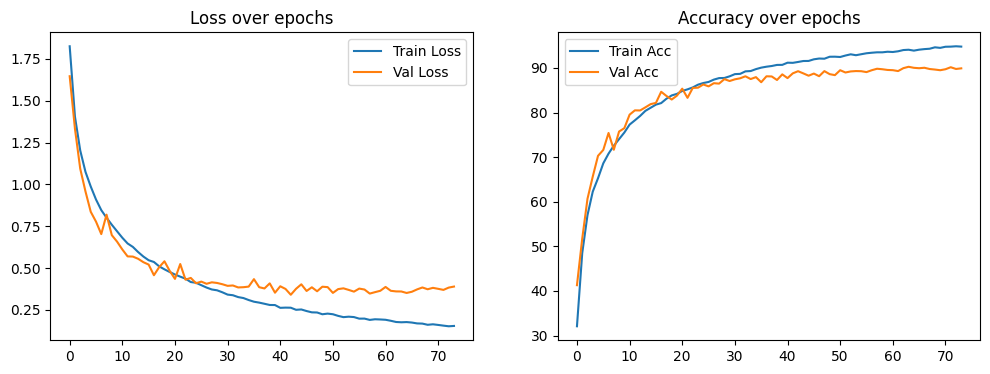


 Training finished. Best validation accuracy: 90.25% (epoch 64)
Loaded best model with validation accuracy: 90.25%


In [24]:
# Initialize and train model
model = create_model()
print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")

train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, epochs=1000, patience=10
)

# Load best model for inference
checkpoint = torch.load('/kaggle/working/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model with validation accuracy: {checkpoint['val_acc']:.2f}%")

# Prediction and Submission

In [25]:
def create_submission(model, test_loader):
    model.eval()
    predictions = []
    image_ids = []
    
    with torch.no_grad():
        pbar = tqdm(test_loader, desc="Predicting")
        for batch_idx, (inputs, img_ids) in enumerate(pbar):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            predictions.extend(predicted.cpu().numpy())
            image_ids.extend(img_ids.numpy())
    
    # Map predictions back to class names
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']
    
    predicted_labels = [class_names[pred] for pred in predictions]
    
    # Create submission DataFrame
    submission = pd.DataFrame({
        'id': image_ids,
        'label': predicted_labels
    })
    
    # Sort by image ID to maintain order
    submission = submission.sort_values('id').reset_index(drop=True)
    
    # Save submission file
    submission.to_csv('/kaggle/working/submission.csv', index=False)
    print(f"Submission file created with {len(submission)} predictions")
    print(submission.head())
    
    return submission

# Create submission
submission = create_submission(model, test_loader)

Predicting: 100%|██████████| 2344/2344 [01:13<00:00, 31.92it/s]


Submission file created with 300000 predictions
   id       label
0   1       truck
1   2    airplane
2   3  automobile
3   4        ship
4   5    airplane
